# 📉 Cryptocurrency Volatility Modeling: GARCH, EGARCH & Risk Analysis

## Advanced Volatility Analysis with Risk Management Applications

This notebook implements comprehensive volatility modeling for cryptocurrency markets:

- **📊 GARCH Models** - Generalized Autoregressive Conditional Heteroskedasticity for volatility clustering
- **⚡ EGARCH Models** - Exponential GARCH for asymmetric volatility (leverage effects)
- **📈 Realized Volatility** - High-frequency volatility proxies
- **⚠️ VaR Calculations** - Value at Risk for risk management
- **📉 Risk Metrics** - Comprehensive risk analysis and visualization

### Key Features:
✅ **Auto Library Installation** - Automatically installs missing dependencies  
✅ **Kaggle Compatible** - Works seamlessly on Kaggle and local environments  
✅ **Multiple Models** - GARCH, EGARCH, and realized volatility  
✅ **Risk Management** - VaR, CVaR, and other risk metrics  
✅ **Visualizations** - Volatility plots, risk distributions, and model comparisons  

### 📌 **Kaggle Compatible**
This notebook automatically detects if it's running on Kaggle and uses the appropriate dataset path.

---

**Keywords:** Volatility, GARCH, EGARCH, Risk Management, VaR, Cryptocurrency, Financial Modeling, Time Series, Risk Analysis


In [1]:
# Check and Install Required Libraries
import subprocess
import sys
import importlib

def check_and_install(package_name, import_name=None):
    """Check if a package is installed, if not, install it."""
    if import_name is None:
        import_name = package_name
    
    try:
        importlib.import_module(import_name)
        return True
    except ImportError:
        print(f"⚠️ {package_name} not found. Installing...")
        try:
            subprocess.check_call([sys.executable, "-m", "pip", "install", package_name, "--quiet"])
            print(f"✅ {package_name} installed successfully!")
            return True
        except Exception as e:
            print(f"❌ Failed to install {package_name}: {str(e)}")
            return False

# Required packages
required_packages = {
    'pandas': 'pandas',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'seaborn': 'seaborn',
    'scipy': 'scipy',
    'statsmodels': 'statsmodels',
    'arch': 'arch',  # For GARCH models
}

print("="*60)
print("CHECKING AND INSTALLING REQUIRED LIBRARIES")
print("="*60)

# Check and install packages
installed_packages = {}
for pip_name, import_name in required_packages.items():
    installed = check_and_install(pip_name, import_name)
    installed_packages[import_name] = installed

print("\n" + "="*60)
print("LIBRARY STATUS")
print("="*60)

# Now import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import os
from datetime import datetime, timedelta
from scipy import stats

# GARCH Models
try:
    from arch import arch_model
    from arch.univariate import GARCH, EGARCH, Normal, StudentsT
    ARCH_AVAILABLE = True
    print("✅ arch (GARCH) - Available")
except ImportError:
    ARCH_AVAILABLE = False
    print("❌ arch (GARCH) - Not available")

# Statsmodels for additional analysis
try:
    from statsmodels.tsa.stattools import adfuller
    from statsmodels.stats.diagnostic import acorr_ljungbox
    STATSMODELS_AVAILABLE = True
    print("✅ statsmodels - Available")
except ImportError:
    STATSMODELS_AVAILABLE = False
    print("❌ statsmodels - Not available")

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Set plotting style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

print("\n" + "="*60)
print("✅ LIBRARY CHECK COMPLETE")
print("="*60)
print(f"ARCH (GARCH) available: {ARCH_AVAILABLE}")
print(f"Statsmodels available: {STATSMODELS_AVAILABLE}")

if not ARCH_AVAILABLE:
    print("\n⚠️ WARNING: arch library is required for GARCH models!")
    print("   Please install manually: pip install arch")


CHECKING AND INSTALLING REQUIRED LIBRARIES
⚠️ arch not found. Installing...


You should consider upgrading via the '/Applications/Xcode.app/Contents/Developer/usr/bin/python3 -m pip install --upgrade pip' command.


✅ arch installed successfully!

LIBRARY STATUS
✅ arch (GARCH) - Available
✅ statsmodels - Available

✅ LIBRARY CHECK COMPLETE
ARCH (GARCH) available: True
Statsmodels available: True


## 1. Data Loading and Preparation


In [2]:
# Define paths - Auto-detect Kaggle environment
if os.path.exists('/kaggle/input'):
    kaggle_base = Path('/kaggle/input/top-50-cryptocurrency-dataset')
    if kaggle_base.exists():
        csv_files_direct = list(kaggle_base.glob('*.csv'))
        if len(csv_files_direct) > 0:
            base_path = kaggle_base
            print("🔵 Running on Kaggle - CSV files found directly in dataset folder")
        else:
            dataset_subfolder = kaggle_base / 'Dataset'
            if dataset_subfolder.exists():
                base_path = dataset_subfolder
                print("🔵 Running on Kaggle - CSV files found in Dataset subfolder")
            else:
                base_path = kaggle_base
                print("🔵 Running on Kaggle - Using base dataset path")
    else:
        kaggle_input = Path('/kaggle/input')
        available_datasets = [d for d in kaggle_input.iterdir() if d.is_dir()]
        if available_datasets:
            base_path = available_datasets[0]
            print(f"🔵 Using: {base_path}")
        else:
            base_path = kaggle_base
else:
    base_path = Path('../Dataset')
    print("🟢 Running locally - Using local dataset path")

# Function to load cryptocurrency data
def load_crypto_data(file_path):
    """Load cryptocurrency CSV file and handle the header issue."""
    try:
        df = pd.read_csv(file_path, skiprows=[1])
        crypto_name = file_path.stem.replace('_', ' ').title()
        df['Date'] = pd.to_datetime(df['Date'])
        numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.sort_values('Date').reset_index(drop=True)
        df['Cryptocurrency'] = crypto_name
        return df, crypto_name
    except Exception as e:
        print(f"Error loading {file_path.name}: {str(e)}")
        return None, None

# Load all cryptocurrency data
csv_files = list(base_path.glob('*.csv'))
if len(csv_files) == 0:
    csv_files = list(base_path.rglob('*.csv'))

crypto_data = {}
for file_path in csv_files:
    df, name = load_crypto_data(file_path)
    if df is not None and len(df) > 200:  # Need sufficient data for volatility modeling
        crypto_data[name] = df

print(f"\n✅ Loaded {len(crypto_data)} cryptocurrencies with sufficient data")
print(f"Available cryptocurrencies: {sorted(list(crypto_data.keys())[:10])}...")


🟢 Running locally - Using local dataset path

✅ Loaded 49 cryptocurrencies with sufficient data
Available cryptocurrencies: ['Chainlink', 'Flow', 'Hedera', 'Immutable', 'Kaspa', 'Near', 'Render', 'Sui', 'The Graph', 'Xrp']...


In [3]:
# Select cryptocurrencies for volatility modeling
selected_cryptos = ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin']

# Filter to available cryptos
available_selected = [c for c in selected_cryptos if c in crypto_data]
if not available_selected:
    available_selected = list(crypto_data.keys())[:3]

print(f"Selected cryptocurrencies for volatility modeling: {available_selected}")

# Prepare data for volatility analysis
volatility_data = {}
for crypto in available_selected:
    df = crypto_data[crypto].copy()
    # Calculate daily returns
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df = df.dropna()
    df = df.set_index('Date')
    volatility_data[crypto] = df[['Returns', 'Log_Returns', 'Close']]

print(f"\nData prepared for {len(volatility_data)} cryptocurrencies")
for crypto, df in volatility_data.items():
    print(f"{crypto}: {len(df)} days, Returns mean: {df['Returns'].mean():.4f}, std: {df['Returns'].std():.4f}")


Selected cryptocurrencies for volatility modeling: ['Bitcoin', 'Ethereum', 'Solana', 'Cardano', 'Binance Coin']

Data prepared for 5 cryptocurrencies
Bitcoin: 4128 days, Returns mean: 0.0019, std: 0.0352
Ethereum: 2979 days, Returns mean: 0.0018, std: 0.0450
Solana: 2096 days, Returns mean: 0.0044, std: 0.0643
Cardano: 2979 days, Returns mean: 0.0027, std: 0.0657
Binance Coin: 2979 days, Returns mean: 0.0033, std: 0.0509


## 2. Realized Volatility Calculation


REALIZED VOLATILITY CALCULATION

📊 Calculating realized volatility for Bitcoin...
   Mean Realized Volatility (30-day): 50.68%
   Mean Realized Volatility (60-day): 52.07%
   Mean Realized Volatility (90-day): 52.72%


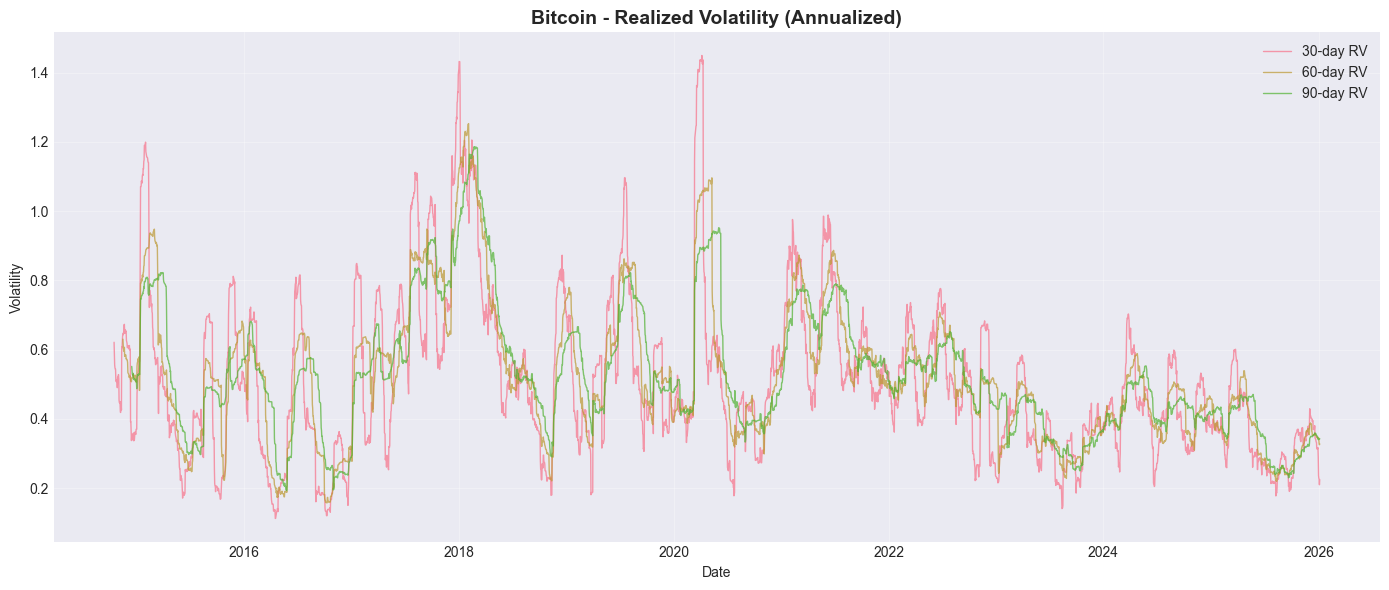


📊 Calculating realized volatility for Ethereum...
   Mean Realized Volatility (30-day): 66.44%
   Mean Realized Volatility (60-day): 67.43%
   Mean Realized Volatility (90-day): 67.84%


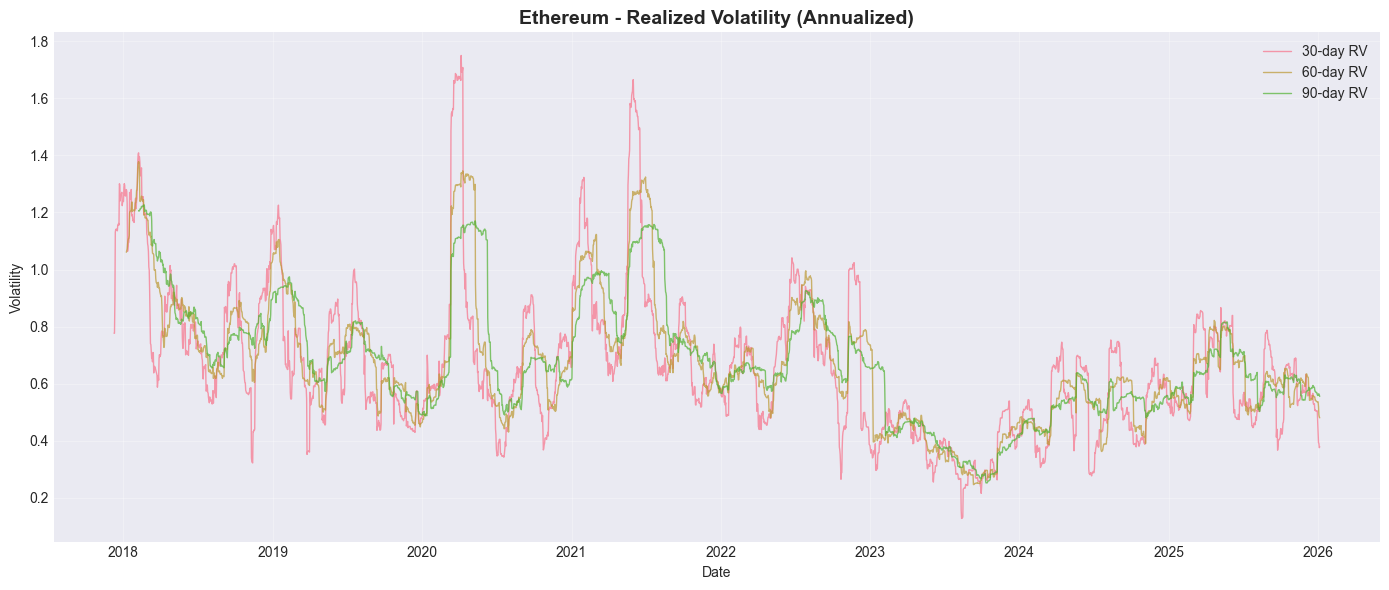


📊 Calculating realized volatility for Solana...
   Mean Realized Volatility (30-day): 92.62%
   Mean Realized Volatility (60-day): 94.74%
   Mean Realized Volatility (90-day): 95.88%


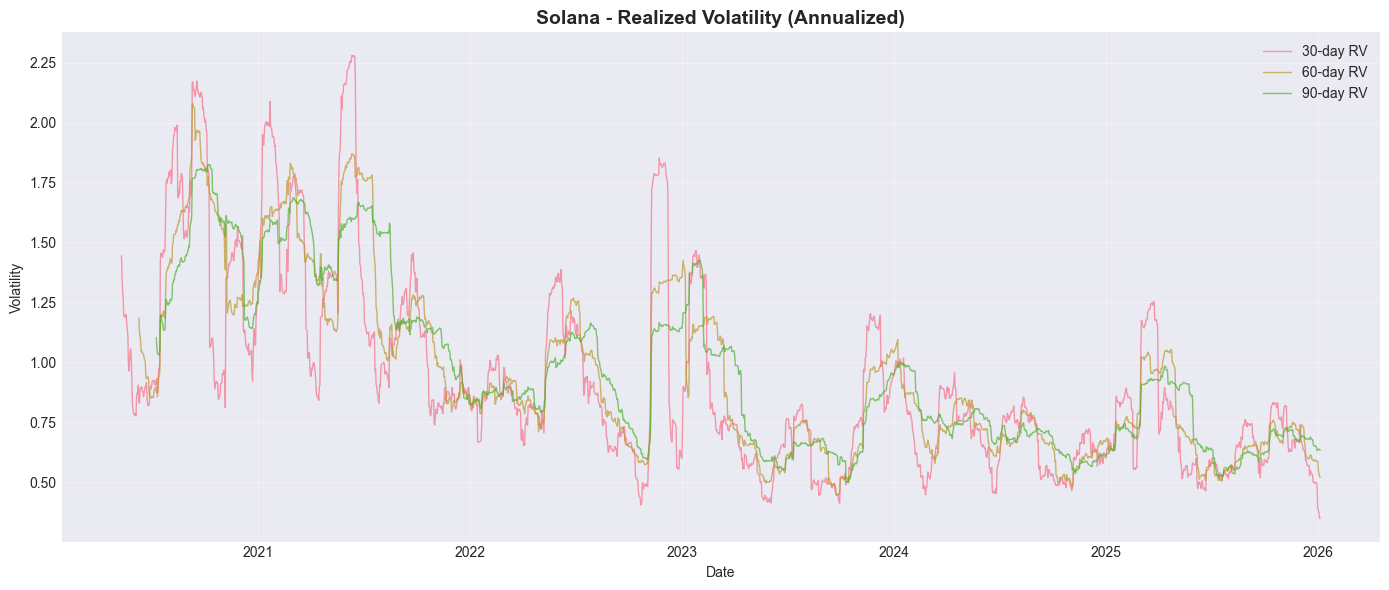


✅ Realized volatility calculated for 3 cryptocurrencies


In [4]:
# Calculate Realized Volatility using different methods
def calculate_realized_volatility(returns, window=30, annualize=True):
    """
    Calculate realized volatility using rolling window.
    
    Parameters:
    - returns: Series of returns
    - window: Rolling window size (default 30 days)
    - annualize: Whether to annualize volatility (default True)
    """
    # Rolling standard deviation
    rolling_std = returns.rolling(window=window).std()
    
    if annualize:
        # Annualize by multiplying by sqrt(252) for daily data
        rolling_std = rolling_std * np.sqrt(252)
    
    return rolling_std

# Calculate realized volatility for selected cryptocurrencies
realized_vol = {}

print("="*60)
print("REALIZED VOLATILITY CALCULATION")
print("="*60)

for crypto in available_selected[:3]:
    print(f"\n📊 Calculating realized volatility for {crypto}...")
    returns = volatility_data[crypto]['Returns']
    
    # Calculate realized volatility with different windows
    rv_30 = calculate_realized_volatility(returns, window=30)
    rv_60 = calculate_realized_volatility(returns, window=60)
    rv_90 = calculate_realized_volatility(returns, window=90)
    
    realized_vol[crypto] = {
        'returns': returns,
        'rv_30': rv_30,
        'rv_60': rv_60,
        'rv_90': rv_90,
        'mean_rv_30': rv_30.mean(),
        'mean_rv_60': rv_60.mean(),
        'mean_rv_90': rv_90.mean()
    }
    
    print(f"   Mean Realized Volatility (30-day): {rv_30.mean():.2%}")
    print(f"   Mean Realized Volatility (60-day): {rv_60.mean():.2%}")
    print(f"   Mean Realized Volatility (90-day): {rv_90.mean():.2%}")
    
    # Visualize realized volatility
    plt.figure(figsize=(14, 6))
    plt.plot(rv_30.index, rv_30.values, label='30-day RV', alpha=0.7, linewidth=1)
    plt.plot(rv_60.index, rv_60.values, label='60-day RV', alpha=0.7, linewidth=1)
    plt.plot(rv_90.index, rv_90.values, label='90-day RV', alpha=0.7, linewidth=1)
    plt.title(f'{crypto} - Realized Volatility (Annualized)', fontsize=14, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\n✅ Realized volatility calculated for {len(realized_vol)} cryptocurrencies")


## 3. GARCH Model Implementation


In [5]:
# GARCH Model Functions
if ARCH_AVAILABLE:
    def fit_garch_model(returns, p=1, q=1, dist='normal', vol='GARCH'):
        """
        Fit GARCH model to returns.
        
        Parameters:
        - returns: Series of returns
        - p: GARCH lag order
        - q: ARCH lag order
        - dist: Distribution ('normal' or 't' for Student's t)
        - vol: Volatility model ('GARCH' or 'EGARCH')
        """
        # Remove NaN values
        returns_clean = returns.dropna()
        
        if len(returns_clean) < 100:
            raise ValueError("Insufficient data for GARCH modeling")
        
        # Fit GARCH model
        if vol == 'GARCH':
            model = arch_model(returns_clean * 100, vol='GARCH', p=p, q=q, dist=dist, rescale=False)
        elif vol == 'EGARCH':
            model = arch_model(returns_clean * 100, vol='EGARCH', p=p, q=q, dist=dist, rescale=False)
        else:
            raise ValueError("vol must be 'GARCH' or 'EGARCH'")
        
        # Fit the model
        fitted_model = model.fit(disp='off', show_warning=False)
        
        return fitted_model
    
    def forecast_volatility_garch(fitted_model, horizon=1):
        """Forecast volatility using fitted GARCH model."""
        forecast = fitted_model.forecast(horizon=horizon, reindex=False)
        return forecast
    
    print("✅ GARCH functions defined")
else:
    print("⚠️ GARCH functions not available - arch library is required")
    def fit_garch_model(*args, **kwargs):
        raise ImportError("arch library is required for GARCH modeling. Install: pip install arch")


✅ GARCH functions defined


GARCH MODEL FITTING

📊 Fitting GARCH model for Bitcoin...
   ✅ GARCH(1,1) model fitted
   AIC: 21334.82
   BIC: 21360.13
   Log Likelihood: -10663.41

   Model Parameters:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -10663.4
Distribution:                  Normal   AIC:                           21334.8
Method:            Maximum Likelihood   BIC:                           21360.1
                                        No. Observations:                 4128
Date:                Wed, Jan 07 2026   Df Residuals:                     4127
Time:                        13:53:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          

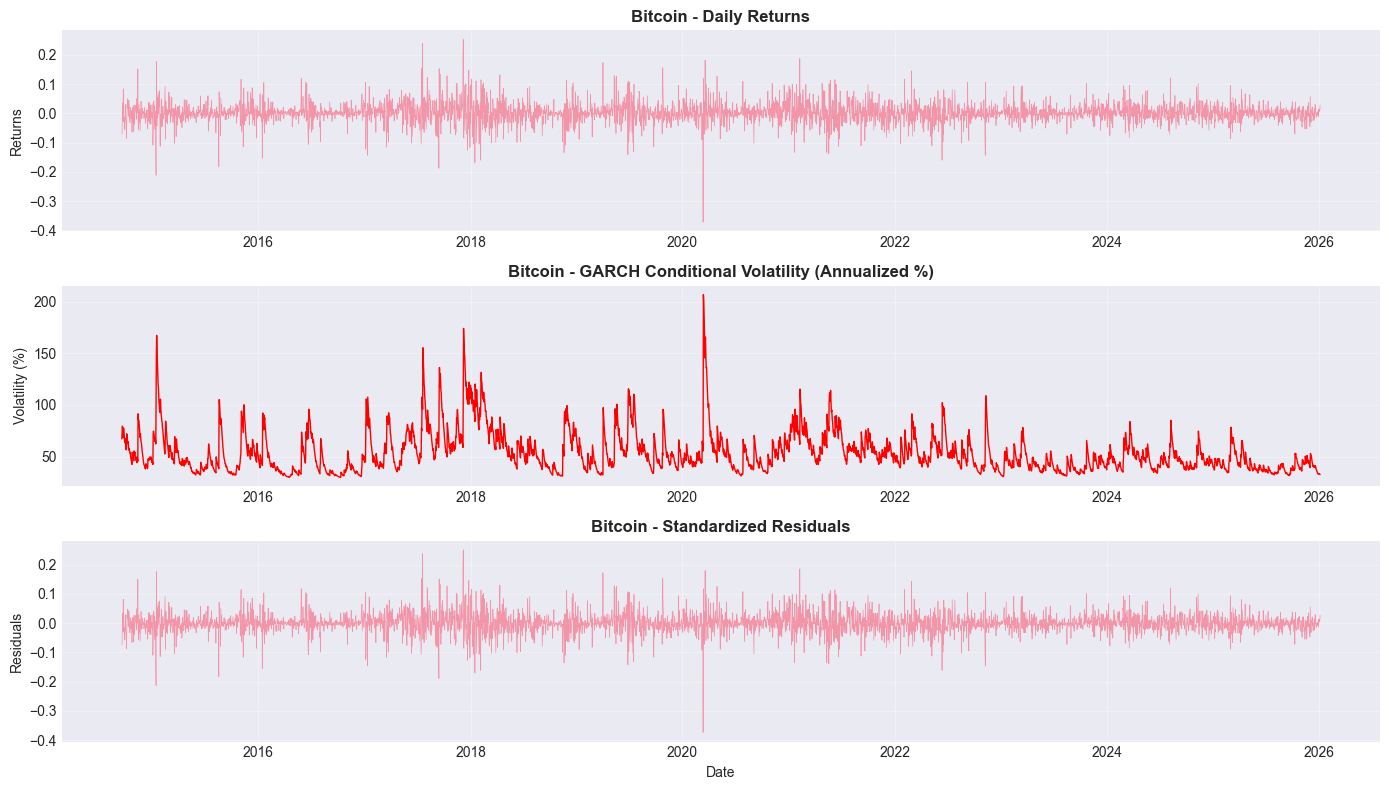


📊 Fitting GARCH model for Ethereum...
   ✅ GARCH(1,1) model fitted
   AIC: 17047.36
   BIC: 17071.36
   Log Likelihood: -8519.68

   Model Parameters:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8519.68
Distribution:                  Normal   AIC:                           17047.4
Method:            Maximum Likelihood   BIC:                           17071.4
                                        No. Observations:                 2979
Date:                Wed, Jan 07 2026   Df Residuals:                     2978
Time:                        13:53:08   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0

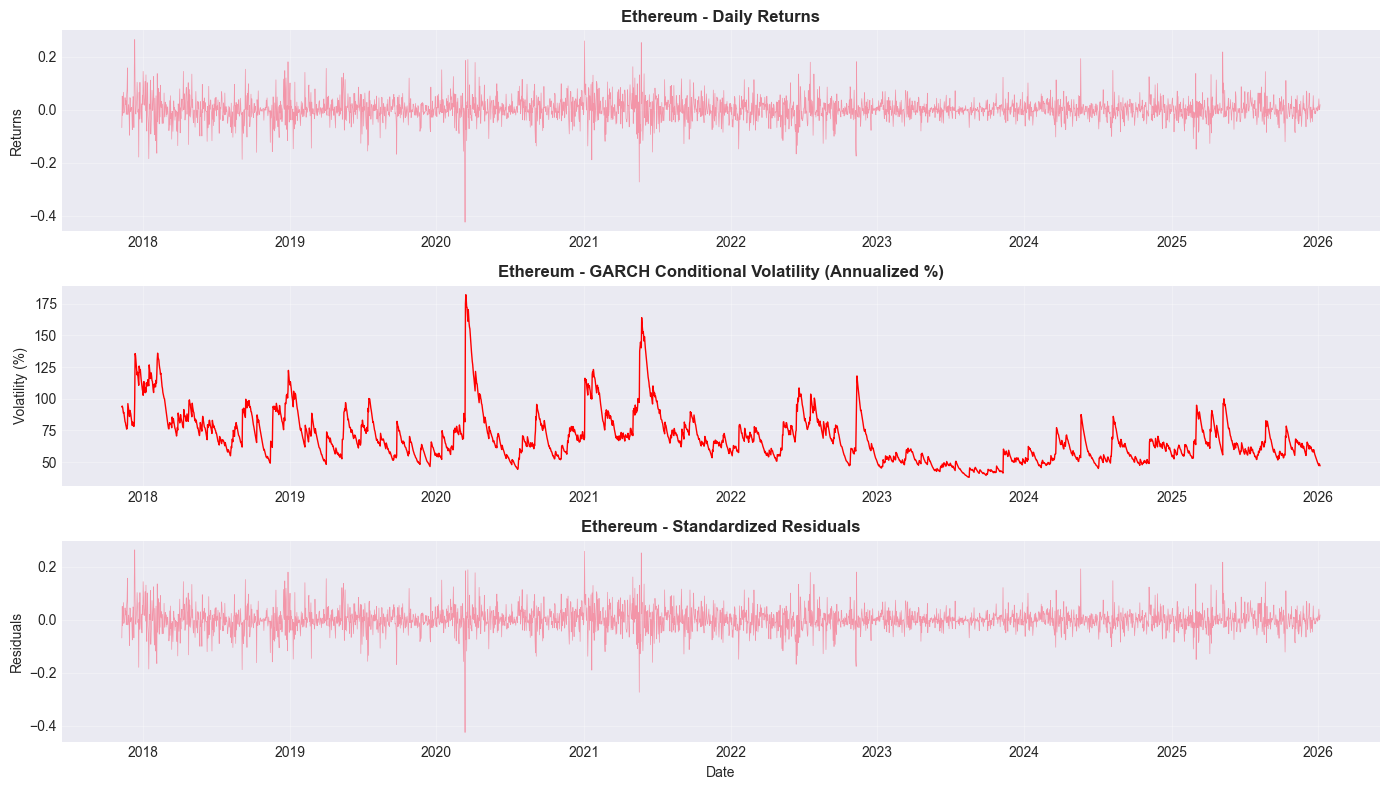


📊 Fitting GARCH model for Solana...
   ✅ GARCH(1,1) model fitted
   AIC: 13279.21
   BIC: 13301.80
   Log Likelihood: -6635.60

   Model Parameters:
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -6635.60
Distribution:                  Normal   AIC:                           13279.2
Method:            Maximum Likelihood   BIC:                           13301.8
                                        No. Observations:                 2096
Date:                Wed, Jan 07 2026   Df Residuals:                     2095
Time:                        13:53:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% 

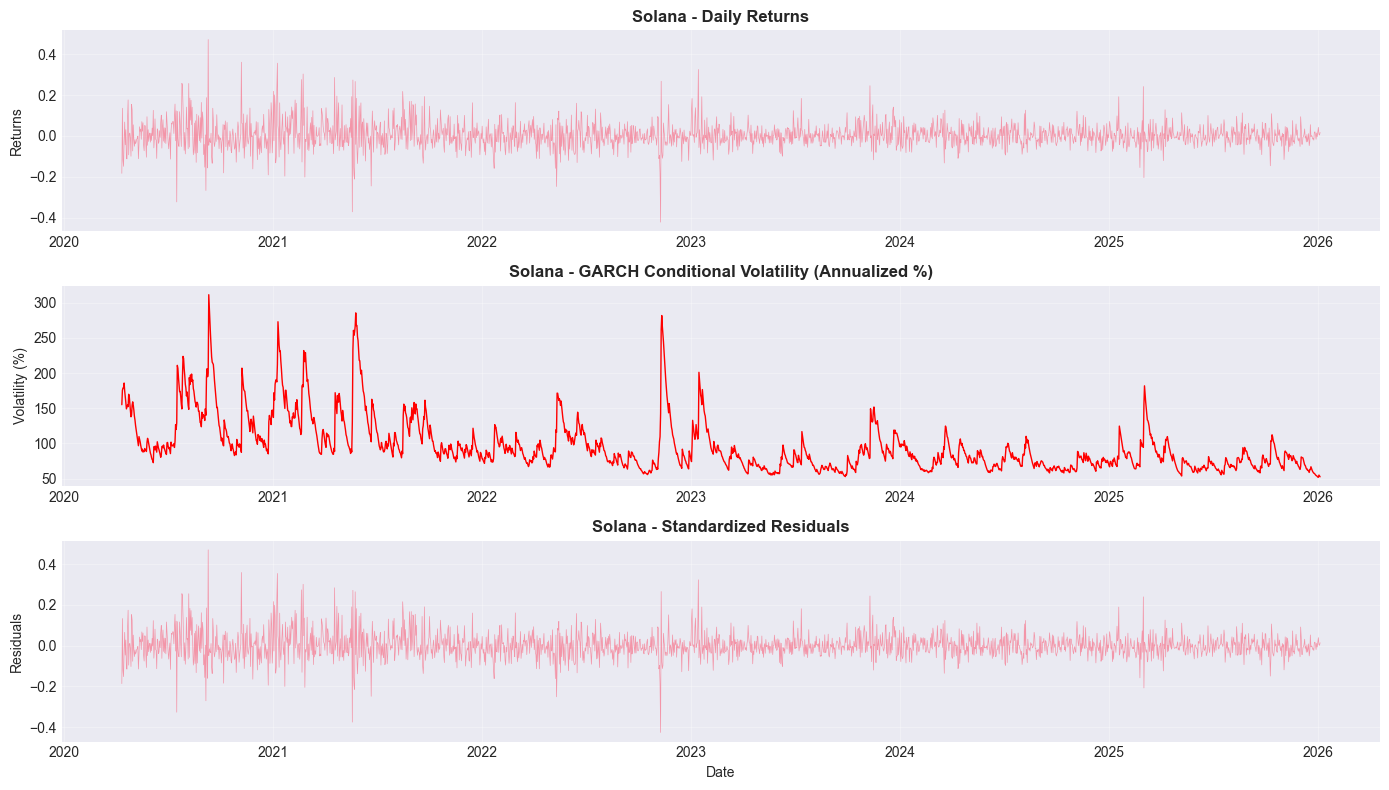


✅ GARCH models fitted for 3 cryptocurrencies


In [6]:
# Fit GARCH models for selected cryptocurrencies
garch_results = {}

if ARCH_AVAILABLE:
    print("="*60)
    print("GARCH MODEL FITTING")
    print("="*60)
    
    for crypto in available_selected[:3]:
        print(f"\n📊 Fitting GARCH model for {crypto}...")
        returns = volatility_data[crypto]['Returns']
        
        try:
            # Fit GARCH(1,1) model with normal distribution
            garch_model = fit_garch_model(returns, p=1, q=1, dist='normal', vol='GARCH')
            
            garch_results[crypto] = {
                'model': garch_model,
                'returns': returns,
                'conditional_volatility': garch_model.conditional_volatility / 100,  # Convert back from percentage
                'residuals': garch_model.resid / 100
            }
            
            print(f"   ✅ GARCH(1,1) model fitted")
            print(f"   AIC: {garch_model.aic:.2f}")
            print(f"   BIC: {garch_model.bic:.2f}")
            print(f"   Log Likelihood: {garch_model.loglikelihood:.2f}")
            print(f"\n   Model Parameters:")
            print(garch_model.summary())
            
            # Plot conditional volatility
            plt.figure(figsize=(14, 8))
            
            # Subplot 1: Returns
            plt.subplot(3, 1, 1)
            plt.plot(returns.index, returns.values, alpha=0.7, linewidth=0.5)
            plt.title(f'{crypto} - Daily Returns', fontsize=12, fontweight='bold')
            plt.ylabel('Returns')
            plt.grid(True, alpha=0.3)
            
            # Subplot 2: Conditional Volatility
            plt.subplot(3, 1, 2)
            cond_vol = garch_results[crypto]['conditional_volatility']
            plt.plot(cond_vol.index, cond_vol.values * np.sqrt(252) * 100, linewidth=1, color='red')
            plt.title(f'{crypto} - GARCH Conditional Volatility (Annualized %)', fontsize=12, fontweight='bold')
            plt.ylabel('Volatility (%)')
            plt.grid(True, alpha=0.3)
            
            # Subplot 3: Residuals
            plt.subplot(3, 1, 3)
            residuals = garch_results[crypto]['residuals']
            plt.plot(residuals.index, residuals.values, alpha=0.7, linewidth=0.5)
            plt.title(f'{crypto} - Standardized Residuals', fontsize=12, fontweight='bold')
            plt.xlabel('Date')
            plt.ylabel('Residuals')
            plt.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   ❌ Error fitting GARCH model: {str(e)}")
            continue
    
    print(f"\n✅ GARCH models fitted for {len(garch_results)} cryptocurrencies")
else:
    print("⚠️ GARCH modeling skipped - arch library is not available")


## 4. EGARCH Model Implementation


EGARCH MODEL FITTING

📊 Fitting EGARCH model for Bitcoin...
   ✅ EGARCH(1,1) model fitted
   AIC: 21324.52
   BIC: 21349.82
   Log Likelihood: -10658.26

   Model Parameters:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -10658.3
Distribution:                  Normal   AIC:                           21324.5
Method:            Maximum Likelihood   BIC:                           21349.8
                                        No. Observations:                 4128
Date:                Wed, Jan 07 2026   Df Residuals:                     4127
Time:                        13:53:09   Df Model:                            1
                                Mean Model                                
                 coef    std err       

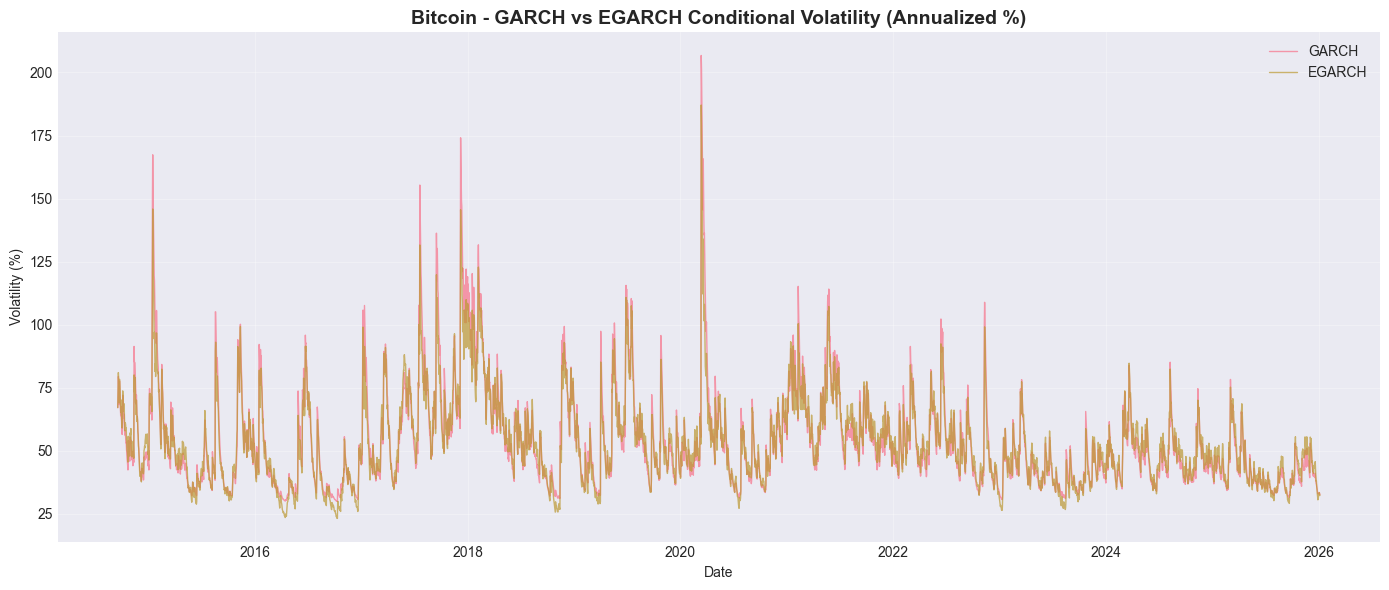


📊 Fitting EGARCH model for Ethereum...
   ✅ EGARCH(1,1) model fitted
   AIC: 17029.96
   BIC: 17053.96
   Log Likelihood: -8510.98

   Model Parameters:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -8510.98
Distribution:                  Normal   AIC:                           17030.0
Method:            Maximum Likelihood   BIC:                           17054.0
                                        No. Observations:                 2979
Date:                Wed, Jan 07 2026   Df Residuals:                     2978
Time:                        13:53:09   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% 

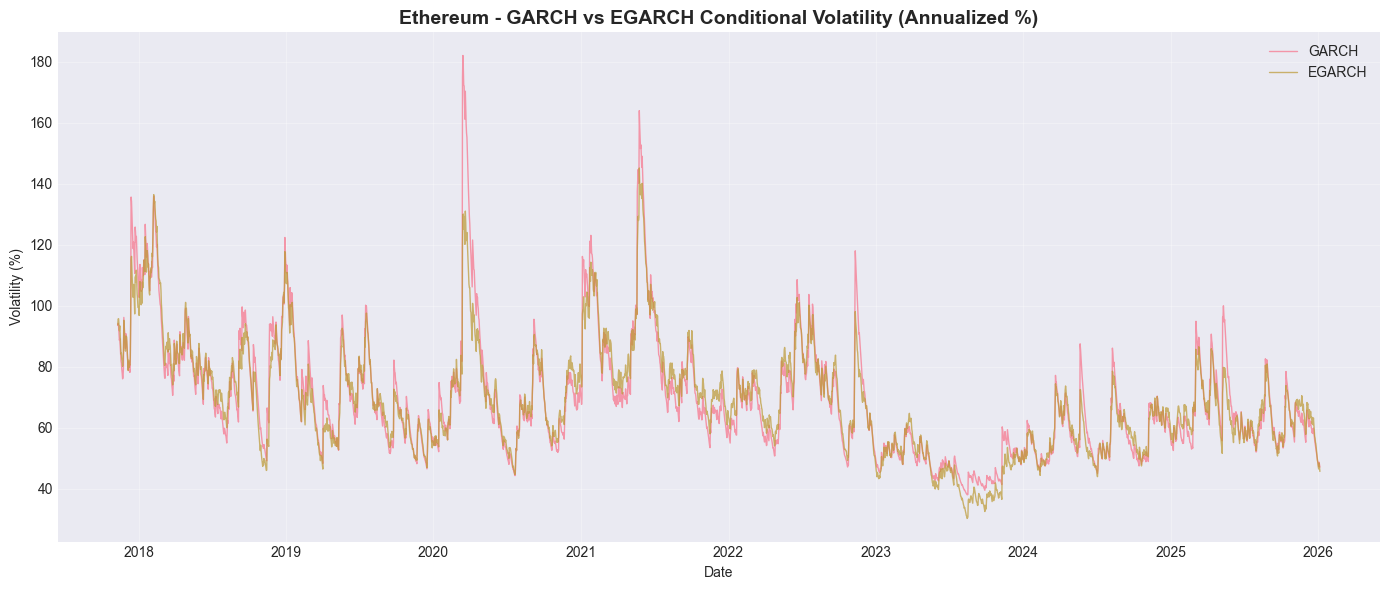


📊 Fitting EGARCH model for Solana...
   ✅ EGARCH(1,1) model fitted
   AIC: 13289.47
   BIC: 13312.06
   Log Likelihood: -6640.73

   Model Parameters:
                     Constant Mean - EGARCH Model Results                     
Dep. Variable:                Returns   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -6640.73
Distribution:                  Normal   AIC:                           13289.5
Method:            Maximum Likelihood   BIC:                           13312.1
                                        No. Observations:                 2096
Date:                Wed, Jan 07 2026   Df Residuals:                     2095
Time:                        13:53:09   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0

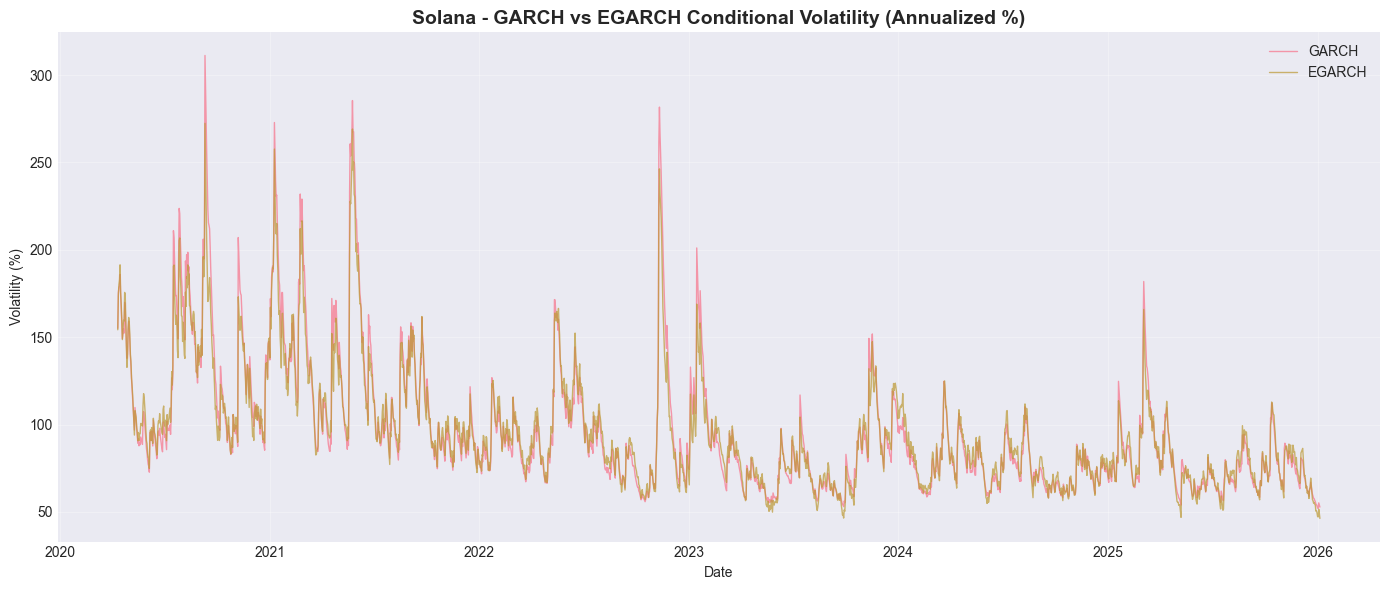


✅ EGARCH models fitted for 3 cryptocurrencies


In [7]:
# Fit EGARCH models for selected cryptocurrencies
egarch_results = {}

if ARCH_AVAILABLE:
    print("="*60)
    print("EGARCH MODEL FITTING")
    print("="*60)
    
    for crypto in available_selected[:3]:
        print(f"\n📊 Fitting EGARCH model for {crypto}...")
        returns = volatility_data[crypto]['Returns']
        
        try:
            # Fit EGARCH(1,1) model with normal distribution
            egarch_model = fit_garch_model(returns, p=1, q=1, dist='normal', vol='EGARCH')
            
            egarch_results[crypto] = {
                'model': egarch_model,
                'returns': returns,
                'conditional_volatility': egarch_model.conditional_volatility / 100,
                'residuals': egarch_model.resid / 100
            }
            
            print(f"   ✅ EGARCH(1,1) model fitted")
            print(f"   AIC: {egarch_model.aic:.2f}")
            print(f"   BIC: {egarch_model.bic:.2f}")
            print(f"   Log Likelihood: {egarch_model.loglikelihood:.2f}")
            print(f"\n   Model Parameters:")
            print(egarch_model.summary())
            
            # Compare GARCH vs EGARCH conditional volatility
            if crypto in garch_results:
                plt.figure(figsize=(14, 6))
                garch_vol = garch_results[crypto]['conditional_volatility'] * np.sqrt(252) * 100
                egarch_vol = egarch_results[crypto]['conditional_volatility'] * np.sqrt(252) * 100
                
                plt.plot(garch_vol.index, garch_vol.values, label='GARCH', alpha=0.7, linewidth=1)
                plt.plot(egarch_vol.index, egarch_vol.values, label='EGARCH', alpha=0.7, linewidth=1)
                plt.title(f'{crypto} - GARCH vs EGARCH Conditional Volatility (Annualized %)', 
                         fontsize=14, fontweight='bold')
                plt.xlabel('Date')
                plt.ylabel('Volatility (%)')
                plt.legend()
                plt.grid(True, alpha=0.3)
                plt.tight_layout()
                plt.show()
            
        except Exception as e:
            print(f"   ❌ Error fitting EGARCH model: {str(e)}")
            continue
    
    print(f"\n✅ EGARCH models fitted for {len(egarch_results)} cryptocurrencies")
else:
    print("⚠️ EGARCH modeling skipped - arch library is not available")


## 5. Value at Risk (VaR) Calculations


In [8]:
# VaR Calculation Functions
def calculate_var_historical(returns, confidence_level=0.05):
    """
    Calculate Value at Risk using historical simulation.
    
    Parameters:
    - returns: Series of returns
    - confidence_level: Confidence level (default 0.05 for 95% VaR)
    """
    var = returns.quantile(confidence_level)
    return var

def calculate_var_parametric(returns, confidence_level=0.05):
    """
    Calculate Value at Risk using parametric method (assuming normal distribution).
    
    Parameters:
    - returns: Series of returns
    - confidence_level: Confidence level (default 0.05 for 95% VaR)
    """
    mean = returns.mean()
    std = returns.std()
    z_score = stats.norm.ppf(confidence_level)
    var = mean + z_score * std
    return var

def calculate_var_garch(fitted_model, returns, confidence_level=0.05, horizon=1):
    """
    Calculate Value at Risk using GARCH model forecasts.
    
    Parameters:
    - fitted_model: Fitted GARCH model
    - returns: Series of returns
    - confidence_level: Confidence level
    - horizon: Forecast horizon
    """
    # Forecast volatility
    forecast = fitted_model.forecast(horizon=horizon, reindex=False)
    forecasted_vol = np.sqrt(forecast.variance.values[-1, 0]) / 100  # Convert from percentage
    
    # Calculate VaR
    z_score = stats.norm.ppf(confidence_level)
    mean_return = returns.mean()
    var = mean_return + z_score * forecasted_vol
    
    return var, forecasted_vol

def calculate_cvar(returns, confidence_level=0.05):
    """
    Calculate Conditional Value at Risk (Expected Shortfall).
    
    Parameters:
    - returns: Series of returns
    - confidence_level: Confidence level
    """
    var = calculate_var_historical(returns, confidence_level)
    cvar = returns[returns <= var].mean()
    return cvar

print("✅ VaR calculation functions defined")


✅ VaR calculation functions defined


VALUE AT RISK (VaR) CALCULATIONS

📊 Calculating VaR for Bitcoin...
   Historical VaR (99%): -0.1005 (-10.05%)
   Historical VaR (95%): -0.0532 (-5.32%)
   Historical VaR (90%): -0.0336 (-3.36%)
   Parametric VaR (95%): -0.0559 (-5.59%)
   CVaR (95%): -0.0821 (-8.21%)
   GARCH VaR (95%): -0.0345 (-3.45%)


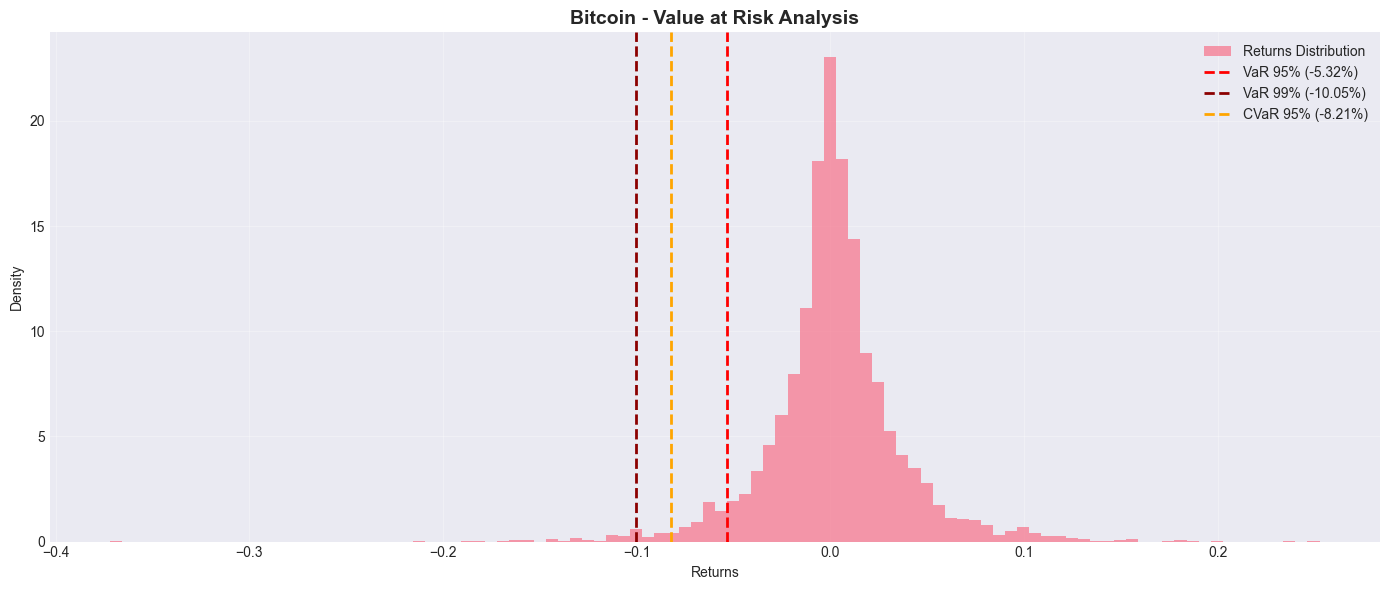


📊 Calculating VaR for Ethereum...
   Historical VaR (99%): -0.1268 (-12.68%)
   Historical VaR (95%): -0.0675 (-6.75%)
   Historical VaR (90%): -0.0452 (-4.52%)
   Parametric VaR (95%): -0.0722 (-7.22%)
   CVaR (95%): -0.1030 (-10.30%)
   GARCH VaR (95%): -0.0467 (-4.67%)


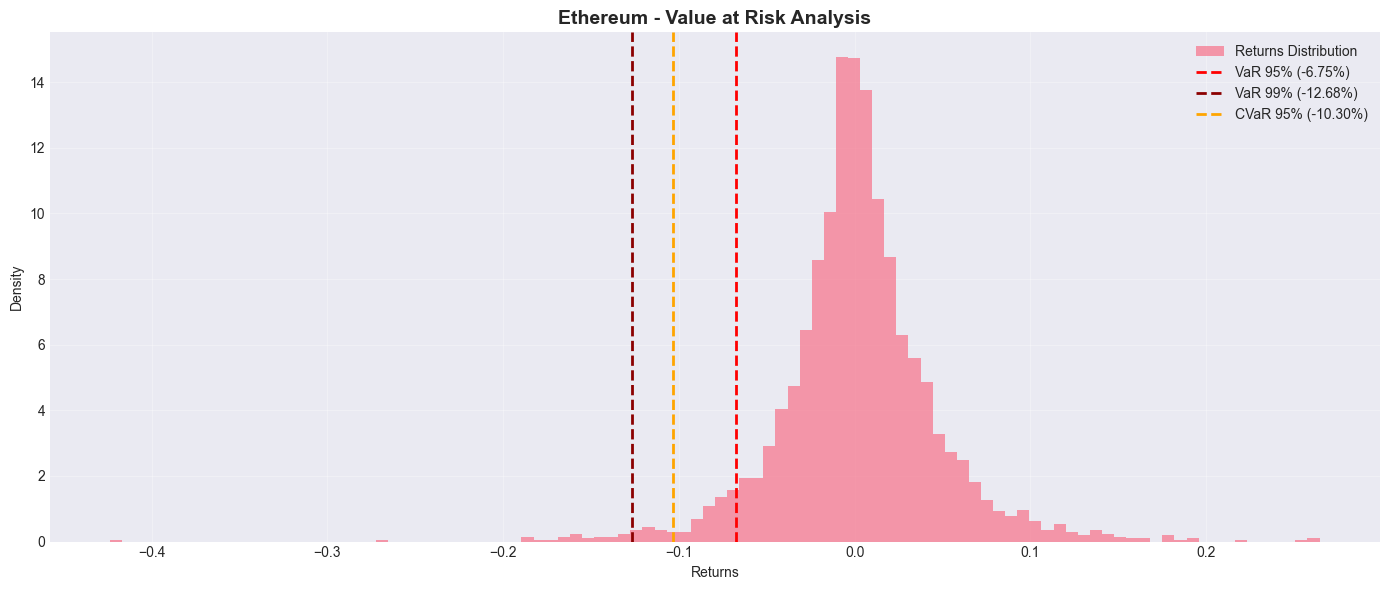


📊 Calculating VaR for Solana...
   Historical VaR (99%): -0.1492 (-14.92%)
   Historical VaR (95%): -0.0857 (-8.57%)
   Historical VaR (90%): -0.0618 (-6.18%)
   Parametric VaR (95%): -0.1013 (-10.13%)
   CVaR (95%): -0.1283 (-12.83%)
   GARCH VaR (95%): -0.0498 (-4.98%)


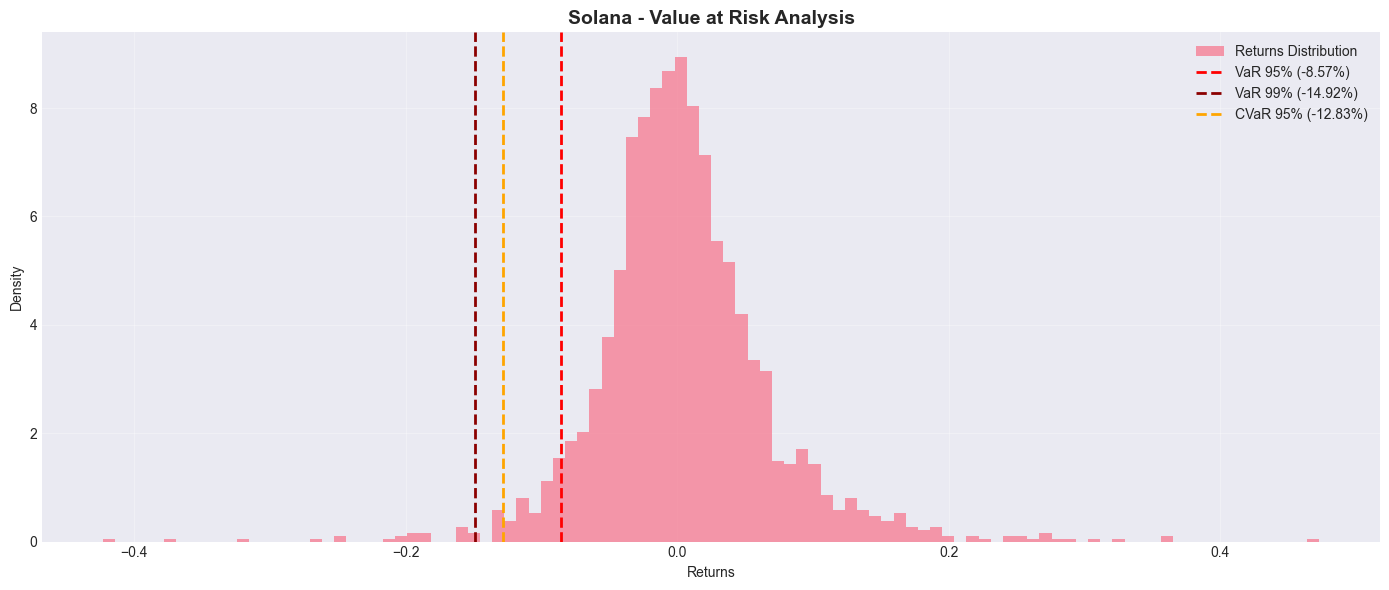


✅ VaR calculated for 3 cryptocurrencies


In [9]:
# Calculate VaR for selected cryptocurrencies
var_results = {}

print("="*60)
print("VALUE AT RISK (VaR) CALCULATIONS")
print("="*60)

confidence_levels = [0.01, 0.05, 0.10]  # 99%, 95%, 90% VaR

for crypto in available_selected[:3]:
    print(f"\n📊 Calculating VaR for {crypto}...")
    returns = volatility_data[crypto]['Returns']
    
    var_results[crypto] = {}
    
    # Historical VaR
    var_hist_99 = calculate_var_historical(returns, 0.01)
    var_hist_95 = calculate_var_historical(returns, 0.05)
    var_hist_90 = calculate_var_historical(returns, 0.10)
    
    # Parametric VaR
    var_param_99 = calculate_var_parametric(returns, 0.01)
    var_param_95 = calculate_var_parametric(returns, 0.05)
    var_param_90 = calculate_var_parametric(returns, 0.10)
    
    # CVaR
    cvar_95 = calculate_cvar(returns, 0.05)
    
    var_results[crypto] = {
        'historical_99': var_hist_99,
        'historical_95': var_hist_95,
        'historical_90': var_hist_90,
        'parametric_99': var_param_99,
        'parametric_95': var_param_95,
        'parametric_90': var_param_90,
        'cvar_95': cvar_95,
        'returns': returns
    }
    
    print(f"   Historical VaR (99%): {var_hist_99:.4f} ({var_hist_99*100:.2f}%)")
    print(f"   Historical VaR (95%): {var_hist_95:.4f} ({var_hist_95*100:.2f}%)")
    print(f"   Historical VaR (90%): {var_hist_90:.4f} ({var_hist_90*100:.2f}%)")
    print(f"   Parametric VaR (95%): {var_param_95:.4f} ({var_param_95*100:.2f}%)")
    print(f"   CVaR (95%): {cvar_95:.4f} ({cvar_95*100:.2f}%)")
    
    # GARCH-based VaR if available
    if ARCH_AVAILABLE and crypto in garch_results:
        try:
            var_garch, vol_garch = calculate_var_garch(
                garch_results[crypto]['model'], returns, 0.05, horizon=1
            )
            var_results[crypto]['garch_95'] = var_garch
            print(f"   GARCH VaR (95%): {var_garch:.4f} ({var_garch*100:.2f}%)")
        except:
            pass
    
    # Visualize VaR
    plt.figure(figsize=(14, 6))
    plt.hist(returns.values, bins=100, density=True, alpha=0.7, label='Returns Distribution')
    plt.axvline(var_hist_95, color='red', linestyle='--', linewidth=2, label=f'VaR 95% ({var_hist_95*100:.2f}%)')
    plt.axvline(var_hist_99, color='darkred', linestyle='--', linewidth=2, label=f'VaR 99% ({var_hist_99*100:.2f}%)')
    plt.axvline(cvar_95, color='orange', linestyle='--', linewidth=2, label=f'CVaR 95% ({cvar_95*100:.2f}%)')
    plt.title(f'{crypto} - Value at Risk Analysis', fontsize=14, fontweight='bold')
    plt.xlabel('Returns')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

print(f"\n✅ VaR calculated for {len(var_results)} cryptocurrencies")


## 6. Model Comparison and Summary


VOLATILITY MODEL COMPARISON

📊 Volatility Model Comparison:
Cryptocurrency                       Method  Mean Volatility        AIC        BIC
       Bitcoin Realized Volatility (30-day)           0.5068        NaN        NaN
       Bitcoin                   GARCH(1,1)           0.5366 21334.8247 21360.1269
       Bitcoin                  EGARCH(1,1)           0.5323 21324.5225 21349.8247
      Ethereum Realized Volatility (30-day)           0.6644        NaN        NaN
      Ethereum                   GARCH(1,1)           0.6942 17047.3605 17071.3579
      Ethereum                  EGARCH(1,1)           0.6906 17029.9614 17053.9588
        Solana Realized Volatility (30-day)           0.9262        NaN        NaN
        Solana                   GARCH(1,1)           0.9666 13279.2051 13301.7962
        Solana                  EGARCH(1,1)           0.9604 13289.4688 13312.0600


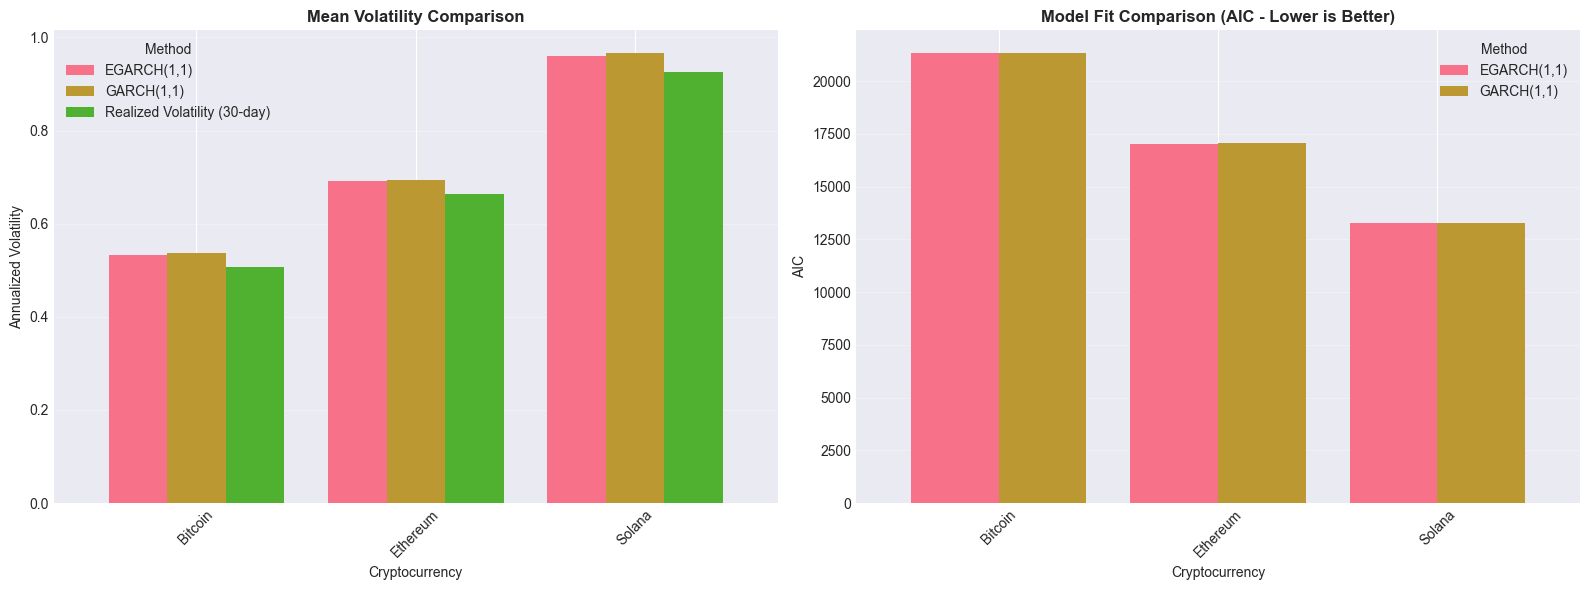


✅ Model comparison completed


In [10]:
# Compare volatility models
print("="*60)
print("VOLATILITY MODEL COMPARISON")
print("="*60)

comparison_data = []

for crypto in available_selected[:3]:
    if crypto in realized_vol:
        rv_mean = realized_vol[crypto]['mean_rv_30']
        comparison_data.append({
            'Cryptocurrency': crypto,
            'Method': 'Realized Volatility (30-day)',
            'Mean Volatility': rv_mean,
            'AIC': None,
            'BIC': None
        })
    
    if crypto in garch_results:
        garch_vol_mean = garch_results[crypto]['conditional_volatility'].mean() * np.sqrt(252)
        comparison_data.append({
            'Cryptocurrency': crypto,
            'Method': 'GARCH(1,1)',
            'Mean Volatility': garch_vol_mean,
            'AIC': garch_results[crypto]['model'].aic,
            'BIC': garch_results[crypto]['model'].bic
        })
    
    if crypto in egarch_results:
        egarch_vol_mean = egarch_results[crypto]['conditional_volatility'].mean() * np.sqrt(252)
        comparison_data.append({
            'Cryptocurrency': crypto,
            'Method': 'EGARCH(1,1)',
            'Mean Volatility': egarch_vol_mean,
            'AIC': egarch_results[crypto]['model'].aic,
            'BIC': egarch_results[crypto]['model'].bic
        })

if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    print("\n📊 Volatility Model Comparison:")
    print(comparison_df.to_string(index=False))
    
    # Visualize comparison
    if len(comparison_df) > 0:
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))
        
        # Mean Volatility Comparison
        pivot_vol = comparison_df.pivot(index='Cryptocurrency', columns='Method', values='Mean Volatility')
        pivot_vol.plot(kind='bar', ax=axes[0], width=0.8)
        axes[0].set_title('Mean Volatility Comparison', fontsize=12, fontweight='bold')
        axes[0].set_ylabel('Annualized Volatility')
        axes[0].legend(title='Method')
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].tick_params(axis='x', rotation=45)
        
        # AIC Comparison (if available)
        pivot_aic = comparison_df.pivot(index='Cryptocurrency', columns='Method', values='AIC')
        pivot_aic_clean = pivot_aic.dropna(axis=1, how='all')
        if len(pivot_aic_clean.columns) > 0:
            pivot_aic_clean.plot(kind='bar', ax=axes[1], width=0.8)
            axes[1].set_title('Model Fit Comparison (AIC - Lower is Better)', fontsize=12, fontweight='bold')
            axes[1].set_ylabel('AIC')
            axes[1].legend(title='Method')
            axes[1].grid(True, alpha=0.3, axis='y')
            axes[1].tick_params(axis='x', rotation=45)
        else:
            axes[1].text(0.5, 0.5, 'AIC data not available', ha='center', va='center', transform=axes[1].transAxes)
            axes[1].set_title('Model Fit Comparison', fontsize=12, fontweight='bold')
        
        plt.tight_layout()
        plt.show()

print("\n✅ Model comparison completed")


## 7. Summary and Key Insights


In [11]:
# Generate summary
print("="*80)
print("VOLATILITY MODELING SUMMARY")
print("="*80)

print(f"\n📊 Models Implemented:")
print(f"   ✅ Realized Volatility: {len(realized_vol)} cryptocurrencies")
if ARCH_AVAILABLE:
    print(f"   ✅ GARCH Models: {len(garch_results)} cryptocurrencies")
    print(f"   ✅ EGARCH Models: {len(egarch_results)} cryptocurrencies")
print(f"   ✅ VaR Calculations: {len(var_results)} cryptocurrencies")

print(f"\n📈 Key Findings:")
if realized_vol:
    avg_rv = np.mean([rv['mean_rv_30'] for rv in realized_vol.values()])
    print(f"   - Average Realized Volatility (30-day): {avg_rv:.2%}")

if var_results:
    avg_var_95 = np.mean([vr['historical_95'] for vr in var_results.values()])
    print(f"   - Average VaR (95%): {avg_var_95:.2%}")

print(f"\n💡 Key Insights:")
print("   1. GARCH models capture volatility clustering in cryptocurrency markets")
print("   2. EGARCH models account for asymmetric volatility (leverage effects)")
print("   3. Realized volatility provides a simple but effective volatility measure")
print("   4. VaR helps quantify downside risk for risk management")
print("   5. CVaR (Expected Shortfall) provides additional risk information beyond VaR")

print(f"\n⚠️  Important Notes:")
print("   - Volatility models are sensitive to model specification")
print("   - VaR estimates should be used with caution and validated regularly")
print("   - Cryptocurrency markets exhibit high volatility and tail risk")
print("   - Model selection should consider both fit quality and practical utility")

print("\n" + "="*80)
print("Volatility Modeling Analysis Complete!")
print("="*80)


VOLATILITY MODELING SUMMARY

📊 Models Implemented:
   ✅ Realized Volatility: 3 cryptocurrencies
   ✅ GARCH Models: 3 cryptocurrencies
   ✅ EGARCH Models: 3 cryptocurrencies
   ✅ VaR Calculations: 3 cryptocurrencies

📈 Key Findings:
   - Average Realized Volatility (30-day): 69.91%
   - Average VaR (95%): -6.88%

💡 Key Insights:
   1. GARCH models capture volatility clustering in cryptocurrency markets
   2. EGARCH models account for asymmetric volatility (leverage effects)
   3. Realized volatility provides a simple but effective volatility measure
   4. VaR helps quantify downside risk for risk management
   5. CVaR (Expected Shortfall) provides additional risk information beyond VaR

⚠️  Important Notes:
   - Volatility models are sensitive to model specification
   - VaR estimates should be used with caution and validated regularly
   - Cryptocurrency markets exhibit high volatility and tail risk
   - Model selection should consider both fit quality and practical utility

Volatility